# Курсовой проект для курса "Алгоритмы анализа данных"

Задание: Примите участие в одном или двух соревнованиях и пришлите свой псевдоним на Kaggle и ссылку на github с решением соревнования по регрессии (https://www.kaggle.com/c/tutors-expected-math-exam-results) или классификации (https://www.kaggle.com/c/choose-tutors).

В скрипте можно использовать только эти импорты:  
import numpy as np  
import pandas as pd  
from sklearn.model_selection import train_test_split  
import matplotlib.pyplot as plt  
import seaborn as sns

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

__Вспомогательные функции__

In [2]:
def normalize(df, name):
    return (df[name] - df[name].min()) / (df[name].max() - df[name].min())

In [3]:
def distribution_chart(df, name):
    sns.distplot(df[name])
    plt.title(name)
    plt.show()

In [4]:
def show_correlations(df):
    plt.figure(figsize = (20,16))
    sns.set(font_scale=1.4)
    sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')
    plt.title('Корреляционная матрица')
    plt.show()

In [5]:
def show_correlation(df, name_one, name_two):
    print(np.cov(df[name_one], df[name_two]))
    grid = sns.jointplot(df[name_one], X_train_norm[name_two], kind='kde')
    grid.fig.set_figwidth(12)
    grid.fig.set_figheight(12)
    plt.show()

Логистическая регрессия

In [6]:
def calc_std_feat(x):
    res = (x - x.mean()) / x.std()
    return res

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
def calc_logloss(y, y_pred):
  err = - np.mean(y * np.log(y_pred + 1e-10) + (1.0 - y) * np.log(1.0 - y_pred + 1e-10))
  return err

In [9]:
def eval_model(X, y, iterations, alpha=1e-4):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    err = 0
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W = W - alpha * (1/n * np.dot((y_pred - y), X.T))
    return (W, err)

In [10]:
def fit(X, y):
    alpha = 1
    epsilon = 1e-4
    err_min = 1e+6
    alpha_min = 1e+6
    count = 1
    errr = 1e+6
    for i in range(10, 10000, 1000):
        while alpha > epsilon:
            W, errr = eval_model(X, y, i, alpha)
            if errr < err_min:
                err_min = errr
                count = i
                alpha_min = alpha
            alpha = alpha / 2
    return eval_model(X, y, count, alpha_min)

In [11]:
def predict(w, X):
    m = X.shape[1]
    y_predicted = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X))
    for i in range(A.shape[1]):
        if (A[:,i] > 0.5): 
            y_predicted[:, i] = 1
        elif (A[:,i] <= 0.5):
            y_predicted[:, i] = 0
    
    return y_predicted

In [12]:
def show_nominative_signs(df):
    for colname in df.select_dtypes(include='object').columns:
        print(str(colname) + '\n\n' + str(df[colname].value_counts()) + '\n' + '*' * 100 + '\n')

In [13]:
def rebuild_nominative_signs(df, columns):
    for column in columns:
        df[column] = df[column].astype(str)
    show_nominative_signs(df)
    for column in df.select_dtypes(include='object').columns:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column, dtype=float)], axis=1)
    for column in columns:
        del df[column]
    return df

Случайный лес

In [14]:
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = np.random.randint(1, n_samples-1)
#             np.random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [15]:
def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    np.random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [16]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [17]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction    

In [18]:
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [19]:
def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [20]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [21]:
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [22]:
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [23]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [24]:
def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [25]:
def gb_predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [26]:
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(gb_predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [27]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [28]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [29]:
def build_forest(n_trees, train_data, train_labels, test_data, test_labels):
    forest = random_forest(train_data, train_labels, n_trees)
    
#     print_forest(forest)
#     print()
    
    train_answers = tree_vote(forest, train_data)
    test_answers = tree_vote(forest, test_data)
    
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
    
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
    
    plt.figure(figsize = (16, 7))
    
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')
    
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

__Описание датасета__

| Наименование поля | Индекс | Описание |
|---|:---:|:---|
| Id  | 0 | идентификатор |
| age | 1 | возраст |
| years_of_experience | 2 | опыт работы |
| lesson_price | 3 | цена |
| qualification | 4 | квалификация |
| physics | 5 | ведет физику |
| chemistry | 6 | ведет химию |
| biology | 7 | ведет биологию |
| english | 8 | ведет английский |
| geography | 9 | ведет географию |
| history | 10 | ведет историю |
| mean_exam_points | 11 | средний балл за ЕГЭ |
| choose | 12 | подходимость |

__Загрузка датасета__

In [30]:
df_train = pd.read_csv('data/choose-tutors/train.csv', sep=',',header=0)

In [31]:
df_train.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


Посмотрим свойства нашего датасета

In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
 12  choose               10000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


В общем-то все нужные признаки без пропусков и нужного типа.

__Приведем типы__

In [33]:
df_train['choose'] = df_train['choose'].astype('float64')

Квалификацию и стаж можно считать номинативными признаками, т.к. они порядковые и имеют малый размер. Проведем обзор номинативных признаков. Перестроим номинативные признаки в бинарные классификационные признаки.

In [34]:
df_train = rebuild_nominative_signs(df_train, ['years_of_experience', 'qualification'])

years_of_experience

0.0    2774
1.0    1842
2.0    1743
3.0    1545
4.0    1177
5.0     581
6.0     234
7.0      73
8.0      22
9.0       9
Name: years_of_experience, dtype: int64
****************************************************************************************************

qualification

1.0    4891
2.0    3033
3.0    2018
4.0      58
Name: qualification, dtype: int64
****************************************************************************************************



In [35]:
df_train.head()

,Id,age,lesson_price,physics,chemistry,biology,english,geography,history,mean_exam_points,...,years_of_experience_4.0,years_of_experience_5.0,years_of_experience_6.0,years_of_experience_7.0,years_of_experience_8.0,years_of_experience_9.0,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0
0,0,35.0,2150.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,52.0,1250.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,29.0,1750.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,33.0,1050.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,46.0,2250.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Посмотрим целевую переменную.

In [36]:
df_train['choose'].value_counts()

0.0    8891
1.0    1109
Name: choose, dtype: int64

In [37]:
target_variable = df_train['choose'].values

Удалим столбцы ненужные в обучении.

In [38]:
del df_train['Id']
del df_train['choose']

Посмотрим статистику нашего датасета.

In [39]:
df_train.describe()

,age,lesson_price,physics,chemistry,biology,english,geography,history,mean_exam_points,years_of_experience_0.0,...,years_of_experience_4.0,years_of_experience_5.0,years_of_experience_6.0,years_of_experience_7.0,years_of_experience_8.0,years_of_experience_9.0,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,45.800900,1702.440000,0.37060,0.121500,0.117200,0.059100,0.02770,0.018000,64.435200,0.277400,...,0.117700,0.058100,0.023400,0.007300,0.002200,0.000900,0.489100,0.303300,0.201800,0.00580
std,8.030274,523.789062,0.48299,0.326724,0.321675,0.235824,0.16412,0.132958,13.595024,0.447738,...,0.322269,0.233944,0.151178,0.085132,0.046855,0.029988,0.499906,0.459707,0.401364,0.07594
min,23.000000,200.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,33.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,40.000000,1300.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,55.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,46.000000,1550.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,63.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,51.000000,2150.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,74.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000
max,68.000000,3950.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,100.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


Очевидно, что надо отмасштабировать следующие признаки датасета:
- age
- lesson_price
- mean_exam_points

Поскольку остальные поля находятся в диапазоне от 0 до 1, то нормализуем наш датасет.

In [40]:
X_train_norm = df_train.copy()

X_train_norm['age'] = normalize(df_train, 'age')
X_train_norm['lesson_price'] = normalize(df_train, 'lesson_price')
X_train_norm['mean_exam_points'] = normalize(df_train, 'mean_exam_points')

Проверим, что получилось.

In [41]:
X_train_norm.describe()

,age,lesson_price,physics,chemistry,biology,english,geography,history,mean_exam_points,years_of_experience_0.0,...,years_of_experience_4.0,years_of_experience_5.0,years_of_experience_6.0,years_of_experience_7.0,years_of_experience_8.0,years_of_experience_9.0,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.506687,0.400651,0.37060,0.121500,0.117200,0.059100,0.02770,0.018000,0.469182,0.277400,...,0.117700,0.058100,0.023400,0.007300,0.002200,0.000900,0.489100,0.303300,0.201800,0.00580
std,0.178451,0.139677,0.48299,0.326724,0.321675,0.235824,0.16412,0.132958,0.202911,0.447738,...,0.322269,0.233944,0.151178,0.085132,0.046855,0.029988,0.499906,0.459707,0.401364,0.07594
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.377778,0.293333,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.328358,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.511111,0.360000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.447761,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.622222,0.520000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.611940,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


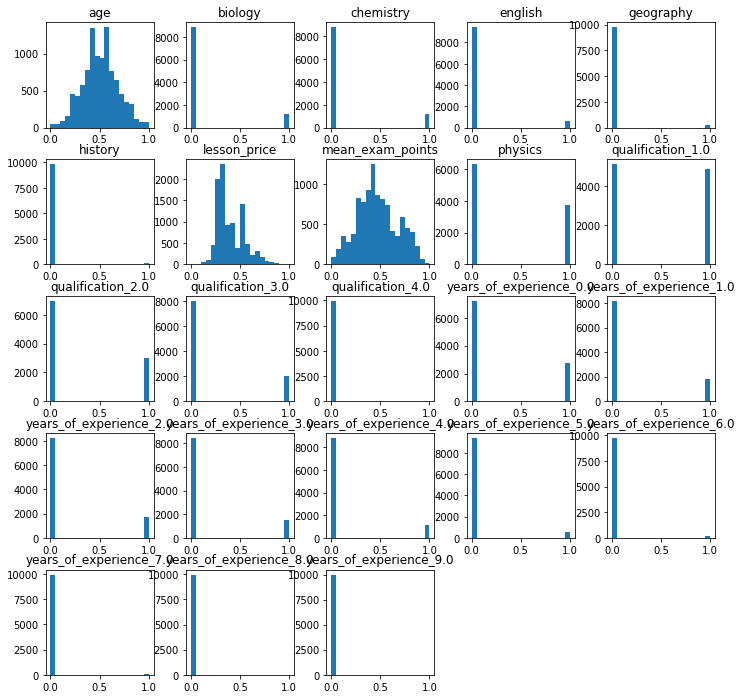

In [42]:
X_train_norm.hist(figsize=(12,12), bins=20, grid=False);

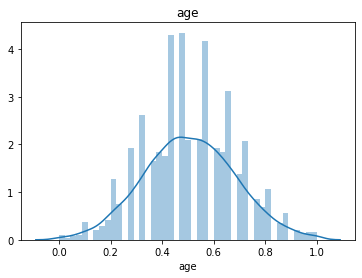

In [43]:
distribution_chart(X_train_norm, 'age')

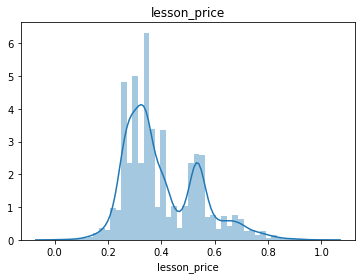

In [44]:
distribution_chart(X_train_norm, 'lesson_price')

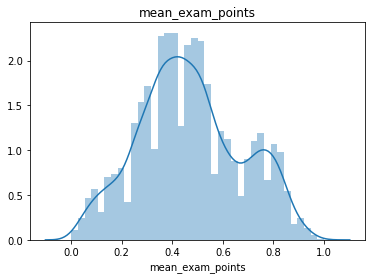

In [45]:
distribution_chart(X_train_norm, 'mean_exam_points')

Посмотрим корреляции, возможно получиться избавится от лишних показателей.

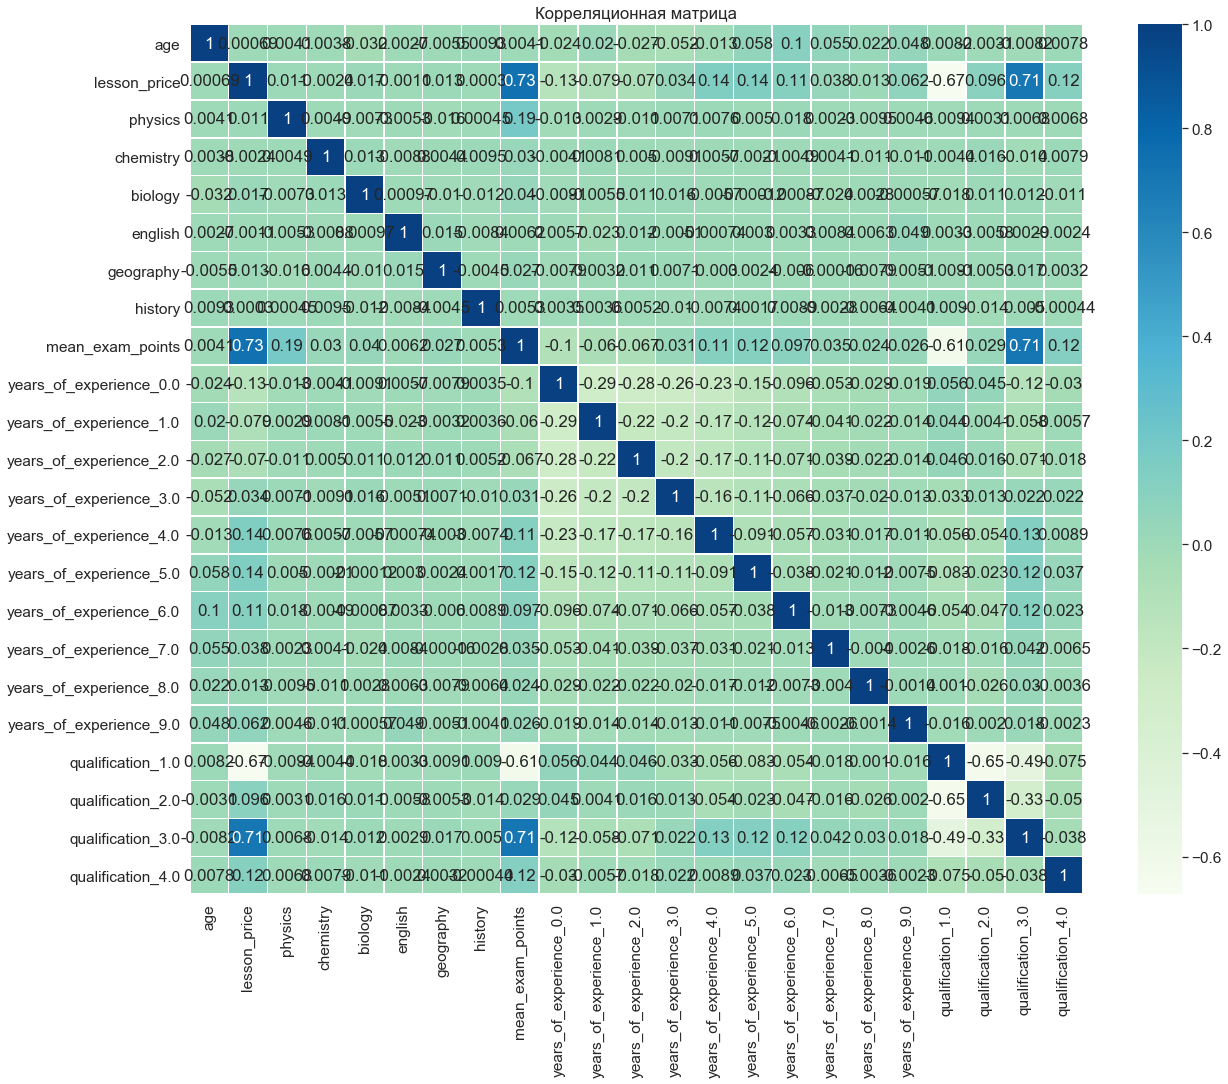

In [46]:
show_correlations(X_train_norm)

Видно, что баллы за ЕГЭ достаточно сильно коррелирует с ценой обучения и квалификацией преподавателя.

Разобъем датасет на тренировочную и тестовую часть тестовую

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_train_norm.values, 
                                                    target_variable, 
                                                    test_size=0.33, 
                                                    shuffle=True, 
                                                    random_state=21)

__Решим с помощью логистической регрессии__

Иницилизируем начальный вектор весов.

In [48]:
X_train_tr = X_train.transpose()
y_train_tr = y_train.reshape(1, y_train.shape[0])
X_test_tr = X_test.transpose()
y_test_tr = y_test.reshape(1, y_test.shape[0])

Тренируем нашу модель.

In [49]:
w, err = fit(X_train_tr, y_train_tr)

In [50]:
train_answers = predict(w, X_train_tr)

In [51]:
test_answers = predict(w, X_test_tr)

In [52]:
train_accuracy = 100.0 - np.mean(np.abs(train_answers - y_train_tr)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(test_answers-y_test_tr)*100.0)

print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Точность на обучающей выборке: 87.209
Точность на тестовой выборке: 87.333


__Решим с помощью случайного леса__

In [53]:
# n_trees = 1000
n_trees = 5000
forest = random_forest(X_train, y_train, n_trees)

In [54]:
train_answers = tree_vote(forest, X_train)
test_answers = tree_vote(forest, X_test)

In [55]:
train_accuracy = accuracy_metric(y_train, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

test_accuracy = accuracy_metric(y_test, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 5000 деревьев на обучающей выборке: 91.582
Точность случайного леса из 5000 деревьев на тестовой выборке: 89.576


Подготовим проверочные данные.

In [56]:
df_test = pd.read_csv('data/choose-tutors/test.csv', sep=',',header=0)

In [57]:
df_test.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,14999.50000,45.924500,1.985700,1699.910000,1.702300,0.372100,0.128100,0.115800,0.049000,0.029200,0.015100,64.149400
std,2886.89568,8.031977,1.771217,526.260094,0.789644,0.483389,0.334218,0.320001,0.215879,0.168375,0.121957,13.570096
min,10000.00000,23.000000,0.000000,300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000
25%,12499.75000,41.000000,0.000000,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000
50%,14999.50000,46.000000,2.000000,1550.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000
75%,17499.25000,51.000000,3.000000,2150.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
max,19999.00000,68.000000,9.000000,3950.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,98.000000


In [58]:
df_test = rebuild_nominative_signs(df_test, ['years_of_experience', 'qualification'])

years_of_experience

0.0    2775
2.0    1804
1.0    1788
3.0    1499
4.0    1187
5.0     601
6.0     246
7.0      68
8.0      29
9.0       3
Name: years_of_experience, dtype: int64
****************************************************************************************************

qualification

1.0    5000
2.0    3026
3.0    1925
4.0      49
Name: qualification, dtype: int64
****************************************************************************************************



In [59]:
df_train.head()

,age,lesson_price,physics,chemistry,biology,english,geography,history,mean_exam_points,years_of_experience_0.0,...,years_of_experience_4.0,years_of_experience_5.0,years_of_experience_6.0,years_of_experience_7.0,years_of_experience_8.0,years_of_experience_9.0,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0
0,35.0,2150.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,52.0,1250.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,29.0,1750.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,33.0,1050.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,46.0,2250.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [60]:
X_test_norm = df_test.copy()

X_test_norm['age'] = normalize(df_test, 'age')
X_test_norm['lesson_price'] = normalize(df_test, 'lesson_price')
X_test_norm['mean_exam_points'] = normalize(df_test, 'mean_exam_points')

In [61]:
del X_test_norm['Id']

In [62]:
X_test_norm.describe()

,age,lesson_price,physics,chemistry,biology,english,geography,history,mean_exam_points,years_of_experience_0.0,...,years_of_experience_4.0,years_of_experience_5.0,years_of_experience_6.0,years_of_experience_7.0,years_of_experience_8.0,years_of_experience_9.0,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.509433,0.383537,0.372100,0.128100,0.115800,0.049000,0.029200,0.015100,0.487112,0.277500,...,0.118700,0.060100,0.02460,0.006800,0.002900,0.000300,0.500000,0.302600,0.192500,0.004900
std,0.178488,0.144181,0.483389,0.334218,0.320001,0.215879,0.168375,0.121957,0.205608,0.447788,...,0.323451,0.237684,0.15491,0.082185,0.053776,0.017319,0.500025,0.459407,0.394283,0.069832
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.273973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.348485,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.511111,0.342466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.469697,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
75%,0.622222,0.506849,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.621212,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
X_test_norm_tr = X_test_norm.transpose()

In [64]:
# y_predicted_test_test = predict(w, X_test_norm_tr)
y_predicted_test_test = tree_vote(forest, X_test_norm.values)

In [65]:
# df_res = pd.DataFrame({'Id':list(df_test['Id']),'choose':list(y_predicted_test_test[0])})
df_res = pd.DataFrame({'Id':list(df_test['Id']),'choose':y_predicted_test_test})

In [66]:
df_res.describe()

,Id,choose
count,10000.00000,10000.000000
mean,14999.50000,0.012600
std,2886.89568,0.111546
min,10000.00000,0.000000
25%,12499.75000,0.000000
50%,14999.50000,0.000000
75%,17499.25000,0.000000
max,19999.00000,1.000000


In [67]:
df_res['choose'].value_counts()

0.0    9874
1.0     126
Name: choose, dtype: int64

In [68]:

df_res.to_csv('data/choose-tutors/submission_log.csv', index=False, encoding='utf-8')